This project pulls data from Google BigQuery to analyze the chicago_taxi_trips.taxi_trips database and predicts if a customer will tip. 

About the data:
* unique_key	- Unique identifier for the trip.	
* taxi_id	- A unique identifier for the taxi.	
* trip_start_timestamp	- When the trip started, rounded to the nearest 15 minutes.	
* trip_end_timestamp	- When the trip ended, rounded to the nearest 15 minutes.	
* trip_seconds	- Time of the trip in seconds.	
* trip_miles	- Distance of the trip in miles.	
* pickup_census_tract	- The Census Tract where the trip began.	
* dropoff_census_tract	- The Census Tract where the trip ended. 	
* pickup_community_area	- The Community Area where the trip began.	
* dropoff_community_area	- The Community Area where the trip ended.	
* fare	- The fare for the trip.	
* tips - The tip for the trip. Cash tips generally will not be recorded.	
* tolls The tolls for the trip.	
* extras - Extra charges for the trip.	
* trip_total - Total cost of the trip, the total of the fare, tips, tolls, and extras.	
* payment_type - Type of payment for the trip.	
* company - The taxi company.	
* pickup_latitude - The latitude of the center of the pickup census tract or the community area if the census tract has been hidden for privacy.	
* pickup_longitude - The longitude of the center of the pickup census tract or the community area if the census tract has been hidden for privacy.	
* pickup_location - The location of the center of the pickup census tract or the community area if the census tract has been hidden for privacy.	
* dropoff_latitude - The latitude of the center of the dropoff census tract or the community area if the census tract has been hidden for privacy.	
* dropoff_longitude - The longitude of the center of the dropoff census tract or the community area if the census tract has been hidden for privacy.	
* dropoff_location - The location of the center of the dropoff census tract or the community area if the census tract has been hidden for privacy.

In [1]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [2]:
%load_ext google.colab.data_table

In [3]:
project_id = 'sixth-flag-316719'

In [4]:
from google.cloud import bigquery
 
client = bigquery.Client(project=project_id)

In [ ]:
# Return the first 10 rows of the database
 
first_ten = client.query('''
SELECT *
FROM
  `bigquery-public-data.chicago_taxi_trips.taxi_trips`
LIMIT 10''').to_dataframe()

In [ ]:
first_ten

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location
0,e5ab129c155c3719216beb5dcbf2aa8ca19e5656,c1aac0b2efe1a131a40f9761b4f5c9dcad9168b29cac42...,2014-07-30 23:00:00+00:00,2014-07-30 23:00:00+00:00,0,0.0,None,None,None,None,8.85,1.77,0.0,0.0,10.62,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,None,None,None,None,None,None
1,a5857e21a97c70612af9b1045b8bd7a626c558ef,c6e0071dc1db129271f6d4833953bb62bd466a9aed3330...,2014-07-30 09:30:00+00:00,2014-07-30 09:30:00+00:00,0,0.0,None,None,None,None,12.25,0.00,0.0,0.0,12.25,Credit Card,T.A.S. - Payment Only,None,None,None,None,None,None
2,2f5f796136c7e11e48d3bb08c8c6d73dfbe0e88c,54044c4ce47d539663e1520272de87e38a14d38ca23a66...,2014-07-13 07:00:00+00:00,2014-07-13 07:00:00+00:00,0,0.0,None,None,None,None,34.25,6.85,0.0,0.0,41.10,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,None,None,None,None,None,None
3,03cf9fabe105982c7b0382c54e002e43dd739c3a,2ee325e10e1eec919fc5bfc4d64ed9951cbab4fb13b3e2...,2014-07-07 23:00:00+00:00,2014-07-07 23:00:00+00:00,0,0.0,None,None,None,None,4.45,1.11,0.0,0.0,5.56,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,None,None,None,None,None,None
4,1ba3648418a92ae0743abf80ca631cca51446d5b,16a233f62883c48f7462a0d5b87191190c49a46fe52f37...,2014-08-28 16:45:00+00:00,2014-08-28 16:45:00+00:00,0,0.0,None,None,None,None,6.85,0.00,0.0,0.0,6.85,Credit Card,T.A.S. - Payment Only,None,None,None,None,None,None
5,9d3efb5b23133ceee6c77930783ddeee65c2eef4,650abe6b4d67899fb67b2631a830ea90b5626ec5724ad7...,2014-07-30 23:15:00+00:00,2014-07-30 23:15:00+00:00,0,0.0,None,None,None,None,6.65,1.33,0.0,0.0,7.98,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,None,None,None,None,None,None
6,8bc900bdd28896467d5f53a5ffef8d648a1ecf1b,803f68095349208b5f15d1f03051b2fab6cc0d21a32610...,2014-07-07 23:00:00+00:00,2014-07-07 23:00:00+00:00,0,0.0,None,None,None,None,26.45,6.61,0.0,0.0,33.06,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,None,None,None,None,None,None
7,6987ab9bf82b69be5354602b2ae6319e4cba4a16,1d9c117a4d3e05e04e1fd27b95acf6451c3b1bffb868c1...,2014-11-07 21:45:00+00:00,2014-11-07 21:45:00+00:00,0,0.0,None,None,None,None,4.85,4.00,0.0,0.0,8.85,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,None,None,None,None,None,None
8,63df25e6f20e889f76b5f5a99c9992df0357f3ad,d402c9f0ddb64e15ee2d2df418717bde115216dd58f753...,2015-08-27 05:15:00+00:00,2015-08-27 05:15:00+00:00,0,0.0,None,None,None,None,39.65,7.93,0.0,0.0,47.58,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,None,None,None,None,None,None
9,cae384153adeca9fbfe3033918b9625267c0cf8d,58f6f45a5c37bd154bac3864d3355c5b4b98e65cbb2663...,2014-07-30 01:30:00+00:00,2014-07-30 01:30:00+00:00,0,0.0,None,None,None,None,35.05,10.52,0.0,0.0,45.57,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,None,None,None,None,None,None


In [ ]:
# Return the timeframe of the data
 
time_window = client.query('''
SELECT MIN(trip_start_timestamp),  MAX(trip_start_timestamp)
FROM
  `bigquery-public-data.chicago_taxi_trips.taxi_trips`''').to_dataframe()

In [ ]:
time_window

,f0_,f1_
0,2013-01-01 00:00:00+00:00,2021-11-01 00:00:00+00:00


In [ ]:
# Return the number of null tips
 
empty_tip = client.query('''
SELECT COUNT(*)
FROM
  `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE
  tips IS NULL;''').to_dataframe()

In [ ]:
empty_tip

,f0_
0,5201


In [5]:
# Create a sampled dataframe for training; dates are year 2018
 
sample_count = 75000
row_count = client.query('''
  SELECT
    COUNT(*) as total
  FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`''').to_dataframe().total[0]
 
training_table = client.query('''
SELECT *
    FROM
          `bigquery-public-data.chicago_taxi_trips.taxi_trips`
    WHERE
           tips IS NOT NULL AND
           trip_seconds IS NOT NULL AND
           trip_miles IS NOT NULL AND
           fare IS NOT NULL AND
           tolls IS NOT NULL AND
           pickup_community_area IS NOT NULL AND
           dropoff_community_area IS NOT NULL AND
           trip_miles > 1 AND # Trips longer than 1 mile
           trip_seconds > 180 AND # Duration longer than 3 minutes
           EXTRACT (YEAR FROM trip_start_timestamp) = 2018
           AND RAND() < %d/%d
''' % (sample_count, row_count)).to_dataframe()
 
print('Full dataset has %d rows' % row_count)

Full dataset has 197917331 rows


In [6]:
training_table.head()

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location
0,7b766b70e73b1db4ebe058bf473780da17edca84,713b6274c7d5358988efab5a8110a97aa4a53b3c9df463...,2018-02-11 02:30:00+00:00,2018-02-11 02:30:00+00:00,360,1.20,1.703106e+10,1.703103e+10,6,3,6.25,2.0,0.0,0.0,8.25,Credit Card,Star North Management LLC,41.942577,-87.647079,POINT (-87.6470785093 41.942577185),41.962179,-87.645379,POINT (-87.6453787624 41.962178629)
1,8c66382367a2fa64ac038cdf9366eb282d43abc3,c07b66852d62e4ca90da2465180f752cf58f1881227d5a...,2018-01-17 12:00:00+00:00,2018-01-17 12:15:00+00:00,540,1.10,1.703108e+10,1.703108e+10,8,8,7.00,2.0,0.0,0.0,9.00,Credit Card,Choice Taxi Association,41.907520,-87.626659,POINT (-87.6266589003 41.90752007470001),41.892508,-87.626215,POINT (-87.6262149064 41.8925077809)
2,e1551aec225da2ee12f7648ef0e5c56880449f9b,6c862bc95ea06a072a03b188ee3f78cadbfdcffdfe64bd...,2018-01-14 05:00:00+00:00,2018-01-14 05:00:00+00:00,300,1.60,1.703106e+10,1.703103e+10,6,3,7.00,0.0,0.0,0.0,7.00,Credit Card,Choice Taxi Association,41.949140,-87.656804,POINT (-87.6568039088 41.9491397709),41.965446,-87.663196,POINT (-87.6631958495 41.9654457842)
3,ef4a997b07b5783057ae1c3e74d3270311735167,89a40bbeb44e22e8169b4ba823c5eee94b324219fbe8c0...,2018-01-05 12:30:00+00:00,2018-01-05 12:45:00+00:00,660,3.90,NaN,NaN,2,12,12.75,0.0,0.0,0.0,12.75,Cash,Taxi Affiliation Services,42.001571,-87.695013,POINT (-87.6950125892 42.001571027),41.993930,-87.758354,POINT (-87.7583535876 41.9939301285)
4,ab453eb0901a123607d4bf50253fa1c181d60baf,14727c10bd08f635b427e7b7ea2c382d66217d42490a42...,2018-06-12 13:15:00+00:00,2018-06-12 13:30:00+00:00,758,2.54,1.703183e+10,1.703108e+10,7,8,10.00,3.0,0.0,0.0,13.50,Credit Card,Sun Taxi,41.914747,-87.654007,POINT (-87.6540070286 41.9147473049),41.892042,-87.631864,POINT (-87.6318639497 41.8920421365)


In [7]:
training_table['company'].nunique() # too many variables

41

# Clean the Data

In [8]:
# drop unnecessary features; we'll use pickup and dropoff community areas instead of locations
 
training_table = training_table.drop(['unique_key', 'taxi_id', 'pickup_location', 'dropoff_location', 'pickup_census_tract', 'dropoff_census_tract', 'company'], axis=1)

In [9]:
training_table.head()

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
0,2018-02-11 02:30:00+00:00,2018-02-11 02:30:00+00:00,360,1.20,6,3,6.25,2.0,0.0,0.0,8.25,Credit Card,41.942577,-87.647079,41.962179,-87.645379
1,2018-01-17 12:00:00+00:00,2018-01-17 12:15:00+00:00,540,1.10,8,8,7.00,2.0,0.0,0.0,9.00,Credit Card,41.907520,-87.626659,41.892508,-87.626215
2,2018-01-14 05:00:00+00:00,2018-01-14 05:00:00+00:00,300,1.60,6,3,7.00,0.0,0.0,0.0,7.00,Credit Card,41.949140,-87.656804,41.965446,-87.663196
3,2018-01-05 12:30:00+00:00,2018-01-05 12:45:00+00:00,660,3.90,2,12,12.75,0.0,0.0,0.0,12.75,Cash,42.001571,-87.695013,41.993930,-87.758354
4,2018-06-12 13:15:00+00:00,2018-06-12 13:30:00+00:00,758,2.54,7,8,10.00,3.0,0.0,0.0,13.50,Credit Card,41.914747,-87.654007,41.892042,-87.631864


In [10]:
# Pre-process dates and time
 
training_table['Month'] = training_table['trip_start_timestamp'].apply(lambda time: time.month)
training_table['Day of Week'] = training_table['trip_start_timestamp'].apply( lambda time: time.dayofweek)
training_table['Hour'] = training_table['trip_start_timestamp'].apply(lambda time: time.hour)

In [11]:
# data now consists of month, day of week, and hour
 
training_table.head()

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,Month,Day of Week,Hour
0,2018-02-11 02:30:00+00:00,2018-02-11 02:30:00+00:00,360,1.20,6,3,6.25,2.0,0.0,0.0,8.25,Credit Card,41.942577,-87.647079,41.962179,-87.645379,2,6,2
1,2018-01-17 12:00:00+00:00,2018-01-17 12:15:00+00:00,540,1.10,8,8,7.00,2.0,0.0,0.0,9.00,Credit Card,41.907520,-87.626659,41.892508,-87.626215,1,2,12
2,2018-01-14 05:00:00+00:00,2018-01-14 05:00:00+00:00,300,1.60,6,3,7.00,0.0,0.0,0.0,7.00,Credit Card,41.949140,-87.656804,41.965446,-87.663196,1,6,5
3,2018-01-05 12:30:00+00:00,2018-01-05 12:45:00+00:00,660,3.90,2,12,12.75,0.0,0.0,0.0,12.75,Cash,42.001571,-87.695013,41.993930,-87.758354,1,4,12
4,2018-06-12 13:15:00+00:00,2018-06-12 13:30:00+00:00,758,2.54,7,8,10.00,3.0,0.0,0.0,13.50,Credit Card,41.914747,-87.654007,41.892042,-87.631864,6,1,13


In [12]:
# Since the data consists of starting hour and duration, start and end time stamps can be dropped
 
training_table = training_table.drop(['trip_start_timestamp', 'trip_end_timestamp'], axis=1)

In [13]:
# Since we have pickup and dropoff communities we shouldn't need longitudes or latitudes
 
training_table = training_table.drop(['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'], axis=1)

In [14]:
training_table.head()

,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,Month,Day of Week,Hour
0,360,1.20,6,3,6.25,2.0,0.0,0.0,8.25,Credit Card,2,6,2
1,540,1.10,8,8,7.00,2.0,0.0,0.0,9.00,Credit Card,1,2,12
2,300,1.60,6,3,7.00,0.0,0.0,0.0,7.00,Credit Card,1,6,5
3,660,3.90,2,12,12.75,0.0,0.0,0.0,12.75,Cash,1,4,12
4,758,2.54,7,8,10.00,3.0,0.0,0.0,13.50,Credit Card,6,1,13


In [15]:
# Creates a categorical variable of tips (whether or not a tip was paid)
 
def tip_indicator(tip):
  if tip > 0:
    return 1
  else:
    return 0

In [16]:
training_table['tip'] = training_table['tips'].apply(lambda tip: tip_indicator(tip))

In [17]:
training_table.head()

,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,Month,Day of Week,Hour,tip
0,360,1.20,6,3,6.25,2.0,0.0,0.0,8.25,Credit Card,2,6,2,1
1,540,1.10,8,8,7.00,2.0,0.0,0.0,9.00,Credit Card,1,2,12,1
2,300,1.60,6,3,7.00,0.0,0.0,0.0,7.00,Credit Card,1,6,5,0
3,660,3.90,2,12,12.75,0.0,0.0,0.0,12.75,Cash,1,4,12,0
4,758,2.54,7,8,10.00,3.0,0.0,0.0,13.50,Credit Card,6,1,13,1


In [18]:
# Drop column tips and trip total. Trip total includes the value of the variable to predict. This model only predicts if the tip value will be greater than 0. 
 
training_table = training_table.drop(['tips', 'trip_total'], axis=1)
training_table.head()

,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tolls,extras,payment_type,Month,Day of Week,Hour,tip
0,360,1.20,6,3,6.25,0.0,0.0,Credit Card,2,6,2,1
1,540,1.10,8,8,7.00,0.0,0.0,Credit Card,1,2,12,1
2,300,1.60,6,3,7.00,0.0,0.0,Credit Card,1,6,5,0
3,660,3.90,2,12,12.75,0.0,0.0,Cash,1,4,12,0
4,758,2.54,7,8,10.00,0.0,0.0,Credit Card,6,1,13,1


In [19]:
# Unique types of payment used
 
training_table['payment_type'].unique()

array(['Credit Card', 'Cash', 'Unknown', 'Prcard', 'Mobile', 'Prepaid',
       'No Charge', 'Pcard', 'Dispute'], dtype=object)

In [20]:
# Current training table length

len(training_table)

3277

In [21]:
training_table.isnull().sum()

trip_seconds              0
trip_miles                0
pickup_community_area     0
dropoff_community_area    0
fare                      0
tolls                     0
extras                    0
payment_type              0
Month                     0
Day of Week               0
Hour                      0
tip                       0
dtype: int64

In [ ]:
# Drop na values if needed
# training_table.dropna(inplace=True)

In [22]:
# training table removing NA values

len(training_table)

3277

In [23]:
print('Min pickup area:', training_table['pickup_community_area'].min())
print('Min dropoff area:', training_table['dropoff_community_area'].min())

print('Max pickup area:', training_table['pickup_community_area'].max())
print('Max dropoff area:', training_table['dropoff_community_area'].max())

Min pickup area: 1
Min dropoff area: 1
Max pickup area: 77
Max dropoff area: 77


In [24]:
# Count of trips with tip received
training_table[training_table['tip'] == 1].count()

trip_seconds              1730
trip_miles                1730
pickup_community_area     1730
dropoff_community_area    1730
fare                      1730
tolls                     1730
extras                    1730
payment_type              1730
Month                     1730
Day of Week               1730
Hour                      1730
tip                       1730
dtype: int64

In [25]:
# Count of trips with no tip received
training_table[training_table['tip'] == 0].count()

trip_seconds              1547
trip_miles                1547
pickup_community_area     1547
dropoff_community_area    1547
fare                      1547
tolls                     1547
extras                    1547
payment_type              1547
Month                     1547
Day of Week               1547
Hour                      1547
tip                       1547
dtype: int64

In [26]:
# Save taxi data to Google drive

from google.colab import drive
drive.mount('drive')

training_table.to_csv('taxi_tips.csv')
!cp taxi_tips.csv "drive/My Drive/Projects/Streamlit/Classification_BigQuery"

Mounted at drive


In [27]:
# Save bike_trip to a Google Storage bucket for Data Studio dashboard

# Data Studio starts with Sunday (equal to 0) as opposed to python, which starts with Monday (equal to 0)
Data_Studio_df = training_table.copy()
Data_Studio_df['Day of Week'] = Data_Studio_df['Day of Week'].map({0:1, 1:2, 2:3, 3:4, 4:5, 5:6, 6:0})

Data_Studio_df.to_csv('taxi_tips.csv')

!gcloud config set project {project_id}

import uuid

bucket_name = 'taxi_tip_data'

!gsutil mb gs://{bucket_name}

!gsutil cp taxi_tips.csv gs://{bucket_name}/

Updated property [core/project].


To take a quick anonymous survey, run:
  $ gcloud survey

Creating gs://taxi_tip_data/...
ServiceException: 409 A Cloud Storage bucket named 'taxi_tip_data' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.
Copying file://taxi_tips.csv [Content-Type=text/csv]...
/ [1 files][158.8 KiB/158.8 KiB]                                                
Operation completed over 1 objects/158.8 KiB.                                    


# Link for Data Studio dashboard

https://datastudio.google.com/reporting/6c64ad63-74d5-43ed-9fa7-3e6ac87c3f5f

# EDA dashboard with Dash

In [ ]:
!pip install jupyter-dash
!pip install pyngrok

In [29]:
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
# Stacked histogram showing fare based on the tip column
fig1 = go.Figure()
fig1.add_trace(go.Histogram(x=training_table[training_table['tip']==1]['fare'], name="fare with tip recieved"))
fig1.add_trace(go.Histogram(x=training_table[training_table['tip']==0]['fare'], name="fare with no tip received"))
fig1.update_layout(barmode='overlay', title='Stacked histogram showing fare based on if a tip was given', xaxis_title='fare') # Overlay histograms
fig1.update_traces(opacity=0.65) # Reduce opacity to see all histograms
 
# Scatterplot of trip_seconds versus fare where the points are colored by the tip column
fig2 = px.scatter(training_table, x='trip_seconds', y='fare', color='tip')
fig2.update_layout(title='Scatterplot of trip_seconds versus fare')
 
# Bar graph showing count of tips received by month
fig3 = go.Figure()
fig3.add_trace(go.Bar(x=training_table['Month'].unique(), y=training_table[training_table['tip']==1].groupby('Month')['tip'].count(), name="Count of tips received by month"))
fig3.update_layout(title='Count of tips received by month', xaxis_title='Month')
 
# Bar graph of average trip length by month
fig4 = go.Figure()
fig4.add_trace(go.Bar(x=training_table['Month'].unique(), y=training_table.groupby('Month')['trip_miles'].mean(), name="Average trip length by month"))
fig4.update_layout(title='Mean trip length by month', xaxis_title='Month')
 
# Scatterplot of trip seconds versus miles where the points are colored by the tip column
fig5 = px.scatter(training_table, x='trip_seconds', y='trip_miles', color='tip')
fig5.update_layout(title='Scatterplot of trip_seconds versus miles')
 
# Bar graph showing count of tips received by day of week
fig6 = go.Figure()
fig6.add_trace(go.Bar(x=training_table['Day of Week'].unique(), y=training_table[training_table['tip']==1].groupby('Day of Week')['tip'].count(), name="Count of tips received by week day"))
fig6.add_trace(go.Bar(x=training_table['Day of Week'].unique(), y=training_table[training_table['tip']==0].groupby('Day of Week')['tip'].count(), name="Count of tips not received by week day"))
fig6.update_layout(title='Count of tips received by week day', xaxis_title='Day')
 
# Bar graph showing count of trips by day of week
fig7 = go.Figure()
fig7.add_trace(go.Bar(x=training_table['Day of Week'].unique(), y=training_table.groupby('Day of Week')['trip_miles'].count(), name="Count of trips by week day"))
fig7.update_layout(title='Count of trips by week day', xaxis_title='Day')

# Stacked histogram showing payment type count based on the tip column
fig8 = go.Figure()
fig8.add_trace(go.Histogram(x=training_table[training_table['tip']==1]['payment_type'], name="payment type with tip recieved"))
fig8.add_trace(go.Histogram(x=training_table[training_table['tip']==0]['payment_type'], name="payment type with no tip received"))
fig8.update_layout(title='Stacked histogram showing payment type based on if a tip was given', xaxis_title='payment type')

In [34]:
fig1.show()

In [47]:
fig2.show()

In [37]:
fig3.show()

In [36]:
fig4.show()

In [38]:
fig5.show()

In [39]:
fig6.show()

In [40]:
fig7.show()

In [41]:
fig8.show()

In [33]:
# Dashboard with Dash
 
from jupyter_dash import JupyterDash
import dash_core_components as dcc
from dash import html
from dash.dependencies import Input, Output
from pyngrok import ngrok
 
app = JupyterDash(__name__)
 
app.layout = html.Div([
    dcc.Graph(figure=fig1),
    dcc.Graph(figure=fig2),
    dcc.Graph(figure=fig3),
    dcc.Graph(figure=fig4),
    dcc.Graph(figure=fig5),
    dcc.Graph(figure=fig6),
    dcc.Graph(figure=fig7),
    dcc.Graph(figure=fig8)
])
 
app.run_server(mode='external')

Dash app running on:


<IPython.core.display.Javascript object>

In [ ]:
! ngrok authtoken 1vXlcIP1hk2NmY9UBuuSHU5gLHX_72emhyJmaGcTmoF6TQfKk

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
public_url = ngrok.connect(addr = '8050')

In [ ]:
#ngrok url link
 
public_url

<NgrokTunnel: "http://db9a-35-201-181-14.ngrok.io" -> "http://localhost:8050">

In [ ]:
ngrok.kill()

The exploratory analysis shows cash payments typically do not tip as opposed to credit card payments.

In [42]:
# count of no tips given by payment type
training_table[training_table['tip']==0]['payment_type'].value_counts()

Cash           1443
Credit Card      72
Prcard           16
Unknown          11
No Charge         2
Dispute           1
Prepaid           1
Pcard             1
Name: payment_type, dtype: int64

In [43]:
# count of tips given by payment type
training_table[training_table['tip']==1]['payment_type'].value_counts()

Credit Card    1674
Mobile           47
Cash              7
Prcard            2
Name: payment_type, dtype: int64

In [44]:
training_table['payment_type'].value_counts()

Credit Card    1746
Cash           1450
Mobile           47
Prcard           18
Unknown          11
No Charge         2
Pcard             1
Dispute           1
Prepaid           1
Name: payment_type, dtype: int64

In [45]:
# Map payment type to number for modeling
training_table['payment_type'] = training_table['payment_type'].map({'Credit Card':0, 'Cash':1, 'Mobile':2, 'Prcard':3, 'Pcard':3, 'No Charge':4, 'Unknown':5, 'Dispute': 5, 'Split': 5})

In [46]:
training_table['payment_type'].value_counts()

0.0    1746
1.0    1450
2.0      47
3.0      19
5.0      12
4.0       2
Name: payment_type, dtype: int64

# Create the model

The y-variable will be the tip feature, indicating if a tip was given (1) or not (0)

## Train-test split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = training_table.drop('tip',axis=1)
y = training_table['tip']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

##Logistic Regression Method

In [ ]:
# Logistic Regression Model
from sklearn.linear_model import LogisticRegression

In [ ]:
logmodel = LogisticRegression()

In [ ]:
logmodel.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
log_Predictions = logmodel.predict(X_test)

## Gradient Boosting Method

In [ ]:
# Gradient Boosting Classification Model
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
GBmodel = GradientBoostingClassifier()

In [ ]:
GBmodel.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
GB_Predictions = GBmodel.predict(X_test)

##Random Forest Method

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rfc = RandomForestClassifier( n_estimators=500, criterion="gini", max_depth=75, min_samples_split=3,min_samples_leaf=2)

In [ ]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=75, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
rfc_pred = rfc.predict(X_test)

## SVM Grid

In [ ]:
from sklearn.svm import SVC

In [ ]:
param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']}

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=3)

In [ ]:
grid.fit(X_train,y_train)

In [ ]:
grid.best_params_

{'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}

In [ ]:
grid.best_estimator_

SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
grid_predictions = grid.predict(X_test)

##Model Evaluation

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Logistic Regression prediction score
print('Logistic Regression prediction score')
print(classification_report(y_test,log_Predictions))

Logistic Regression prediction score
              precision    recall  f1-score   support

           0       0.86      0.87      0.87       477
           1       0.88      0.88      0.88       534

    accuracy                           0.88      1011
   macro avg       0.87      0.88      0.88      1011
weighted avg       0.88      0.88      0.88      1011



In [ ]:
print(confusion_matrix(y_test,log_Predictions))

[[416  61]
 [ 65 469]]


In [ ]:
# Gradient Boosting prediction score
print('Gradient Boosting prediction score')
print(classification_report(y_test,GB_Predictions))

Gradient Boosting prediction score
              precision    recall  f1-score   support

           0       1.00      0.93      0.96       477
           1       0.94      1.00      0.97       534

    accuracy                           0.96      1011
   macro avg       0.97      0.96      0.96      1011
weighted avg       0.97      0.96      0.96      1011



In [ ]:
print(confusion_matrix(y_test,GB_Predictions))

[[442  35]
 [  2 532]]


In [ ]:
# Random Forest prediction score
print('Random Forest prediction score')
print(classification_report(y_test,rfc_pred))

Random Forest prediction score
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       477
           1       0.94      0.99      0.97       534

    accuracy                           0.96      1011
   macro avg       0.97      0.96      0.96      1011
weighted avg       0.97      0.96      0.96      1011



In [ ]:
print(confusion_matrix(y_test,rfc_pred))

[[443  34]
 [  3 531]]


In [ ]:
# SVM prediction score
print('SVM prediction score')
print(classification_report(y_test,grid_predictions))

SVM prediction score
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       477
           1       0.85      0.89      0.87       534

    accuracy                           0.86      1011
   macro avg       0.86      0.86      0.86      1011
weighted avg       0.86      0.86      0.86      1011



In [ ]:
print(confusion_matrix(y_test,grid_predictions))

[[396  81]
 [ 60 474]]


In [ ]:
print("Gradient accuracy on training set: {:.3f}".format(GBmodel.score(X_train,  y_train)))
print("Gradient accuracy on test set: {:.3f}".format(GBmodel.score(X_test,  y_test)))

Gradient accuracy on training set: 0.975
Gradient accuracy on test set: 0.963


In [ ]:
import numpy as np

importances = GBmodel.feature_importances_

indices = np.argsort(importances)

In [ ]:
importances

array([0.00881268, 0.00650633, 0.00137733, 0.00293922, 0.00181482,
       0.        , 0.00106137, 0.96424805, 0.00544339, 0.0022964 ,
       0.00550043])

In [ ]:
indices

array([ 5,  6,  2,  4,  9,  3,  8, 10,  1,  0,  7])

In [ ]:
Features = X_train.columns
Features

Index(['trip_seconds', 'trip_miles', 'pickup_community_area',
       'dropoff_community_area', 'fare', 'tolls', 'extras', 'payment_type',
       'Month', 'Day of Week', 'Hour'],
      dtype='object')

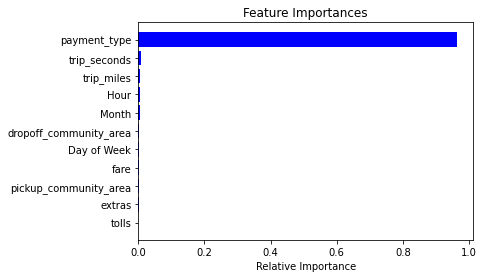

In [ ]:
import matplotlib.pyplot as plt
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [Features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Payment type is most important predictor

# Save model

In [ ]:
from google.colab import drive
 
drive.mount('drive')

Mounted at drive


In [ ]:
import joblib

In [ ]:
# Save the model to Drive

joblib.dump(GBmodel,'/content/drive/MyDrive/Projects/Streamlit/Classification_BigQuery/GBmodel.joblib')

['/content/drive/MyDrive/Projects/Streamlit/Classification_BigQuery/GBmodel.joblib']

# Load model

In [ ]:
from google.colab import drive
 
drive.mount('drive')

Mounted at drive


In [ ]:
import joblib
import pandas as pd

In [ ]:
# Load the model
loaded_GB = joblib.load('/content/drive/MyDrive/Projects/Streamlit/Classification_BigQuery/GBmodel.joblib')

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
%load_ext google.colab.data_table

In [ ]:
project_id = 'sixth-flag-316719'

In [ ]:
from google.cloud import bigquery
 
client = bigquery.Client(project=project_id)

In [ ]:
# Create an evaluation table to predict tips for 2019 Jan-Mar
 
sample_count = 40000
row_count = client.query('''
  SELECT
    COUNT(*) as total
  FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`''').to_dataframe().total[0]
 
evaluation_table = client.query('''
SELECT *
    FROM
          `bigquery-public-data.chicago_taxi_trips.taxi_trips`
    WHERE
           tips IS NOT NULL AND
           trip_seconds IS NOT NULL AND
           trip_miles IS NOT NULL AND
           fare IS NOT NULL AND
           tolls IS NOT NULL AND
           pickup_community_area IS NOT NULL AND
           dropoff_community_area IS NOT NULL AND
           trip_miles > 1 AND
           trip_seconds > 180 AND
           EXTRACT (YEAR FROM trip_start_timestamp) = 2019 AND
           (EXTRACT (MONTH FROM trip_start_timestamp) >=1 AND EXTRACT (MONTH FROM trip_start_timestamp)<=3)
           AND RAND() < %d/%d
''' % (sample_count, row_count)).to_dataframe()
 
# drop unnecessary features
 
evaluation_table = evaluation_table.drop(['unique_key', 'taxi_id', 'pickup_location', 'dropoff_location', 'pickup_census_tract', 'dropoff_census_tract', 'company'], axis=1)
 
# Pre-process dates and time

evaluation_table['Month'] = evaluation_table['trip_start_timestamp'].apply(lambda time: time.month)
evaluation_table['Day of Week'] = evaluation_table['trip_start_timestamp'].apply( lambda time: time.dayofweek)
evaluation_table['Hour'] = evaluation_table['trip_start_timestamp'].apply(lambda time: time.hour)

# Since the data consists of start time and duration, start and end time stamps can be dropped
 
evaluation_table = evaluation_table.drop(['trip_start_timestamp', 'trip_end_timestamp'], axis=1)
 
# Since we have the pickup and drop communities we shouldn't need the longitudes or latitudes
 
evaluation_table = evaluation_table.drop(['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'], axis=1)
 
# Drop column tips and trip total. Trip total includes the value of the variable to predict. This model only predicts if the tip value will be present. 
evaluation_table = evaluation_table.drop(['tips', 'trip_total'], axis=1)
 
evaluation_table['payment_type'] = evaluation_table['payment_type'].map({'Credit Card':0, 'Cash':1, 'Mobile':2, 'Prcard':3, 'Pcard':3, 'No Charge':4, 'Unknown':5, 'Dispute': 5, 'Split': 5})
 
evaluation_table.dropna(inplace=True)

In [ ]:
evaluation_table.columns

Index(['trip_seconds', 'trip_miles', 'pickup_community_area',
       'dropoff_community_area', 'fare', 'tolls', 'extras', 'payment_type',
       'Month', 'Day of Week', 'Hour'],
      dtype='object')

In [ ]:
import numpy as np

importances = loaded_GB.feature_importances_

indices = np.argsort(importances)

In [ ]:
Features = evaluation_table.columns

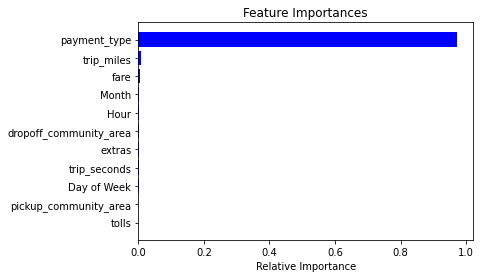

In [ ]:
import matplotlib.pyplot as plt
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [Features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Payment type is most important predictor

In [ ]:
predictions = loaded_GB.predict(evaluation_table)
predictions = pd.DataFrame(predictions)

In [ ]:
evaluation_table['prediction'] = predictions

In [ ]:
evaluation_table.head(15)

,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tolls,extras,payment_type,Month,Day of Week,Hour,prediction
0,1020,3.2,28,33,12.50,0.0,1.0,1,1,4,19,0
1,600,1.4,32,8,7.50,0.0,0.0,1,1,2,23,0
2,900,1.4,32,32,9.00,0.0,0.0,0,1,4,18,1
3,480,2.1,8,6,8.50,0.0,1.0,1,1,6,2,0
4,1800,17.5,56,6,44.25,0.0,4.0,0,1,6,18,1
5,600,2.4,8,24,10.00,0.0,0.0,0,1,6,4,1
6,1320,6.5,33,26,19.75,0.0,0.0,5,1,6,8,0
7,300,2.3,8,7,8.75,0.0,0.0,1,1,2,3,0
8,360,2.3,2,14,8.50,0.0,1.0,1,2,6,0,0
9,600,3.7,6,3,12.25,0.0,0.0,0,2,6,6,1


# EDA Dashboard with Dash

In [ ]:
!pip install jupyter-dash
!pip install pyngrok

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
 
dmap = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
mmap = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'July', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
evaluation_table.sort_values('Day of Week', inplace=True)
evaluation_table['Day of Week'] = evaluation_table['Day of Week'].map(dmap)
evaluation_table['Month'] = evaluation_table['Month'].map(mmap)

In [ ]:
# Stacked histogram showing fare based on the tip prediction column
fig1 = go.Figure()
fig1.add_trace(go.Histogram(x=evaluation_table[evaluation_table['prediction']==1]['fare'], name="fare with predicted tip"))
fig1.add_trace(go.Histogram(x=evaluation_table[evaluation_table['prediction']==0]['fare'], name="fare with no predicted tip"))
fig1.update_layout(barmode='overlay', title='Stacked histogram showing fare based on if a tip is predicted', xaxis_title='fare') # Overlay histograms
fig1.update_traces(opacity=0.65) # Reduce opacity to see all histograms
 
# Scatterplot of trip_seconds versus fare where the points are colored by the tip prediction
fig2 = px.scatter(evaluation_table, x='trip_seconds', y='fare', color='prediction')
fig2.update_layout(title='Scatterplot of trip_seconds versus fare')
 
# Bar graph of average trip length by week day
fig3 = go.Figure()
fig3.add_trace(go.Bar(x=evaluation_table['Day of Week'].unique(), y=evaluation_table.groupby('Day of Week')['trip_miles'].mean(), name="Average trip length by week day"))
fig3.update_layout(title='Mean trip length by week day', xaxis_title='Week Day')
 
# Scatterplot of trip seconds versus miles where the points are colored by tip prediction
fig4 = px.scatter(evaluation_table, x='trip_seconds', y='trip_miles', color='prediction')
fig4.update_layout(title='Scatterplot of trip_seconds versus miles')
 
# Bar graph showing count of tip predictions per day of week
fig5 = go.Figure()
fig5.add_trace(go.Bar(x=evaluation_table['Day of Week'].unique(), y=evaluation_table[evaluation_table['prediction']==1].groupby('Day of Week')['prediction'].count(), name="Count of tips prediction by week day"))
fig5.add_trace(go.Bar(x=evaluation_table['Day of Week'].unique(), y=evaluation_table[evaluation_table['prediction']==0].groupby('Day of Week')['prediction'].count(), name="Count of tips not predicted by week day"))
fig5.update_layout(title='Count of tips predicted by week day', xaxis_title='Day')
 
# Bar graph showing count of trips by day of week
fig6 = go.Figure()
fig6.add_trace(go.Bar(x=evaluation_table['Day of Week'].unique(), y=evaluation_table.groupby('Day of Week')['trip_miles'].count(), name="Count of trips by week day"))
fig6.update_layout(title='Count of trips by week day', xaxis_title='Day')

# Stacked histogram showing payment type count based on the prediction column
fig7 = go.Figure()
fig7.add_trace(go.Histogram(x=evaluation_table[evaluation_table['prediction']==1]['payment_type'], name="payment type with tip predicted"))
fig7.add_trace(go.Histogram(x=evaluation_table[evaluation_table['prediction']==0]['payment_type'], name="payment type with no tip predicted"))
fig7.update_layout(title='Stacked histogram showing payment type based on if a tip is predicted', xaxis_title='payment type')

In [ ]:
# Dashboard with Dash
 
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
import dash_table
from dash.dependencies import Input, Output
from pyngrok import ngrok
 
app = JupyterDash(__name__)
 
app.layout = html.Div([
    dcc.Graph(figure=fig1),
    dcc.Graph(figure=fig2),
    dcc.Graph(figure=fig3),
    dcc.Graph(figure=fig4),
    dcc.Graph(figure=fig5),
    dcc.Graph(figure=fig6),
    dcc.Graph(figure=fig7),
    dash_table.DataTable(
        id='table',
        columns=[{"name": i, "id": i} 
                 for i in evaluation_table.columns],
        data=evaluation_table.to_dict('records'),
        style_cell=dict(textAlign='left'),
        style_header=dict(backgroundColor="paleturquoise"),
        style_data=dict(backgroundColor="lavender")
    )
])
 
app.run_server(mode='external')

Dash app running on:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning:


The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning:


The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning:


The dash_table package is deprecated. Please replace
`import dash_table` with `from dash import dash_table`

Also, if you're using any of the table format helpers (e.g. Group), replace 
`from dash_table.Format import Group` with 
`from dash.dash_table.Format import Group`



<IPython.core.display.Javascript object>

In [ ]:
! ngrok authtoken 1vXlcIP1hk2NmY9UBuuSHU5gLHX_72emhyJmaGcTmoF6TQfKk

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
public_url = ngrok.connect(addr = '8050')

In [ ]:
#ngrok url link
 
public_url

<NgrokTunnel: "http://becd-34-125-159-33.ngrok.io" -> "http://localhost:8050">

In [ ]:
ngrok.kill()

# Streamlit Model Deployment link
https://share.streamlit.io/taylorec/classification_bigquery/main/Classification_BQ.py